In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

matplotlib==3.10.0
numpy==1.26.4
pandas==1.5.3
seaborn==0.13.2


In [3]:
df = pd.read_csv('../dataset/D05.SI.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/D05.SI.csv'

In [4]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [5]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 0.275013
iter 20. reward: 0.589134
iter 30. reward: -0.616551
iter 40. reward: 0.148797
iter 50. reward: -2.353342
iter 60. reward: 0.244243
iter 70. reward: 0.860072
iter 80. reward: -2.567530
iter 90. reward: 0.754682
iter 100. reward: 1.759774
iter 110. reward: 2.011394
iter 120. reward: 1.589849
iter 130. reward: 2.072654
iter 140. reward: 1.742862
iter 150. reward: 2.013698
iter 160. reward: 1.399138
iter 170. reward: 2.511940
iter 180. reward: 2.263536
iter 190. reward: 1.953460
iter 200. reward: 2.200116
iter 210. reward: 2.229922
iter 220. reward: 2.345266
iter 230. reward: 2.659235
iter 240. reward: 2.380744
iter 250. reward: 2.618890
iter 260. reward: 2.690712
iter 270. reward: 0.293080
iter 280. reward: 2.926052
iter 290. reward: 2.827749
iter 300. reward: 2.662549
iter 310. reward: 2.515703
iter 320. reward: 2.540849
iter 330. reward: 2.539115
iter 340. reward: 2.866608
iter 350. reward: 2.095895
iter 360. reward: 2.540158
iter 370. reward: 3.090269
iter 38

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 0: buy 1 unit at price 29.920124, total balance 9970.079876
day 1: buy 1 unit at price 29.988712, total balance 9940.091164
day 2: buy 1 unit at price 29.954418, total balance 9910.136745
day 3: buy 1 unit at price 30.571682, total balance 9879.565063
day 4: buy 1 unit at price 30.717426, total balance 9848.847637
day 5: buy 1 unit at price 30.434513, total balance 9818.413124
day 6: buy 1 unit at price 30.931753, total balance 9787.481371
day 7: buy 1 unit at price 31.403273, total balance 9756.078098
day 8: buy 1 unit at price 30.888884, total balance 9725.189215
day 9: buy 1 unit at price 30.786009, total balance 9694.403206
day 11: buy 1 unit at price 30.940327, total balance 9663.462879
day 12: buy 1 unit at price 31.137506, total balance 9632.325373
day 13: buy 1 unit at price 30.893837, total balance 9601.431536
day 14: buy 1 unit at price 30.937349, total balance 9570.494186
day 15: buy 1 unit at price 31.146208, total balance 9539.347979
day 16, sell 1 unit at price 31.328

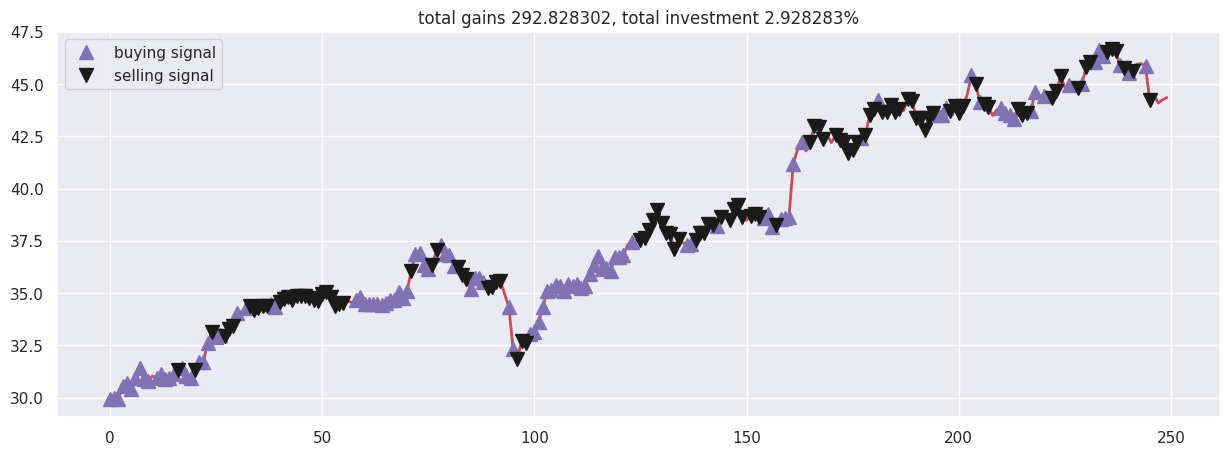

In [8]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()


Processing U11.SI...
U11.SI: Final Portfolio = 26557.832999260463, Shares Held = 0, Last Price = 38.2599983215332


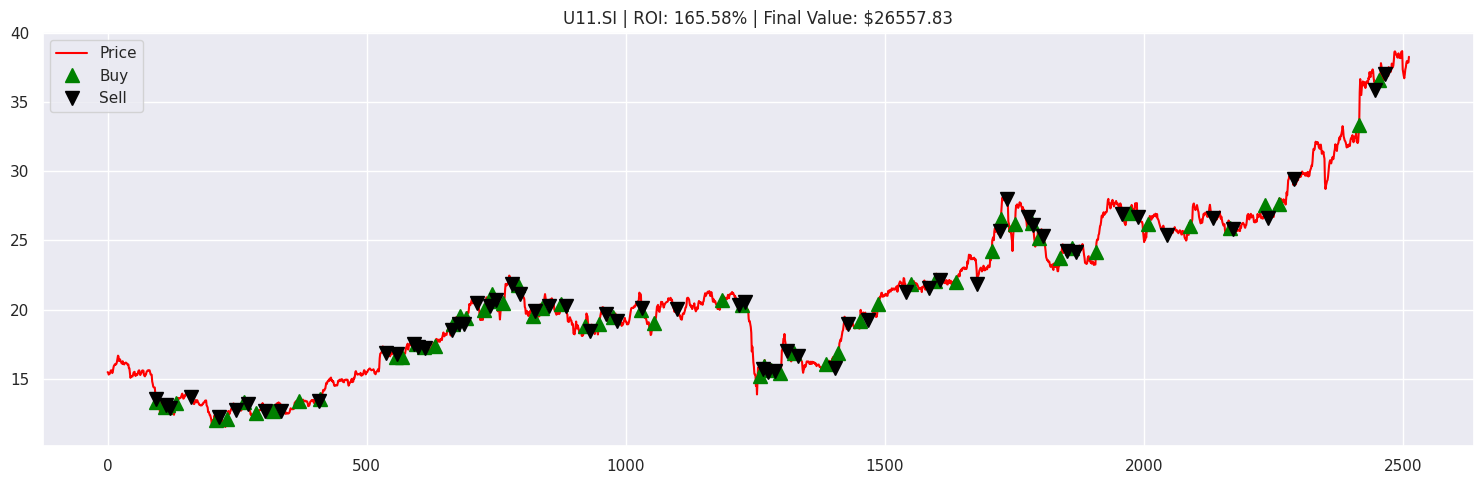


Processing C38U.SI...
C38U.SI: Final Portfolio = 1.291876252340444, Shares Held = 9100.0, Last Price = 2.0999999046325684


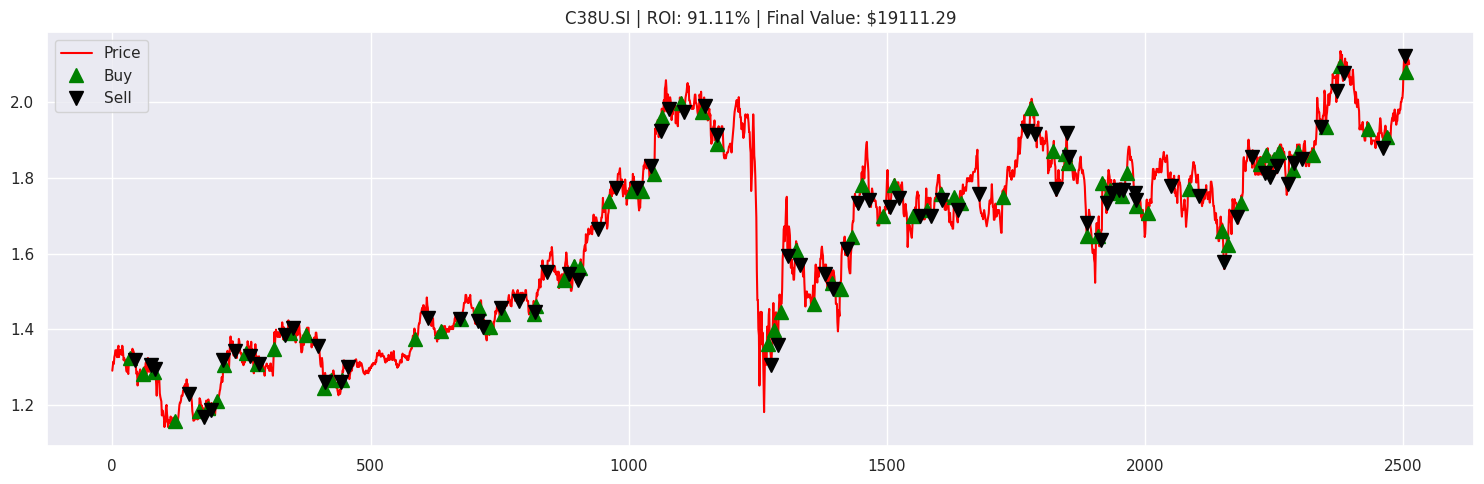


Processing Q0F.SI...
Q0F.SI: Final Portfolio = 17278.760789675496, Shares Held = 0, Last Price = 2.0249998569488525


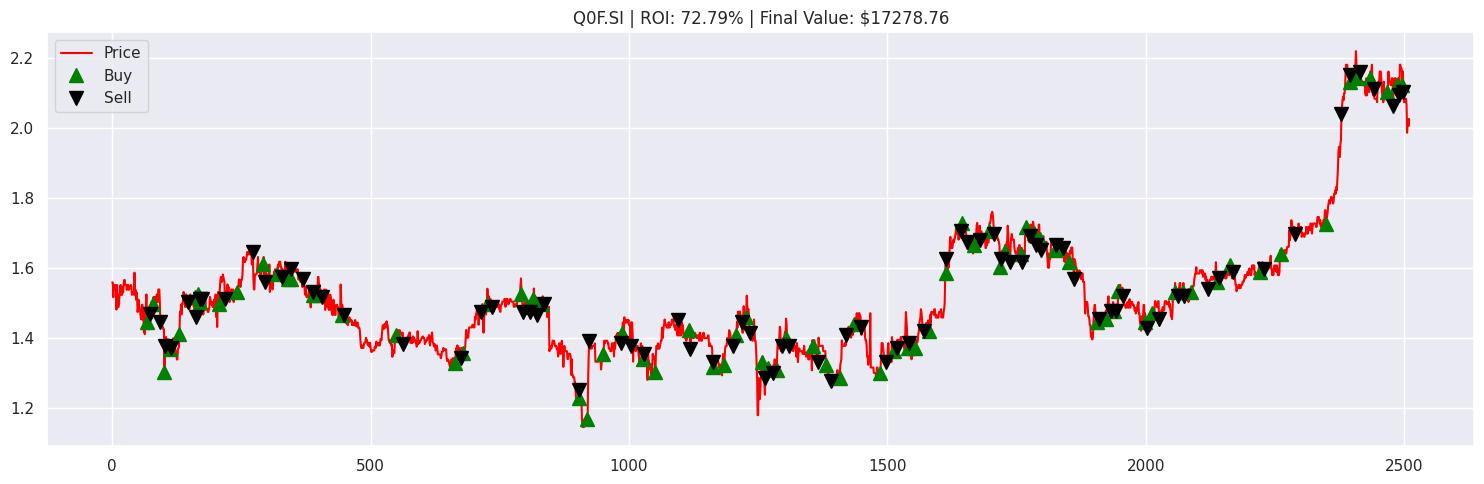


Processing S68.SI...
S68.SI: Final Portfolio = 4.532214278013271, Shares Held = 1261.0, Last Price = 13.25


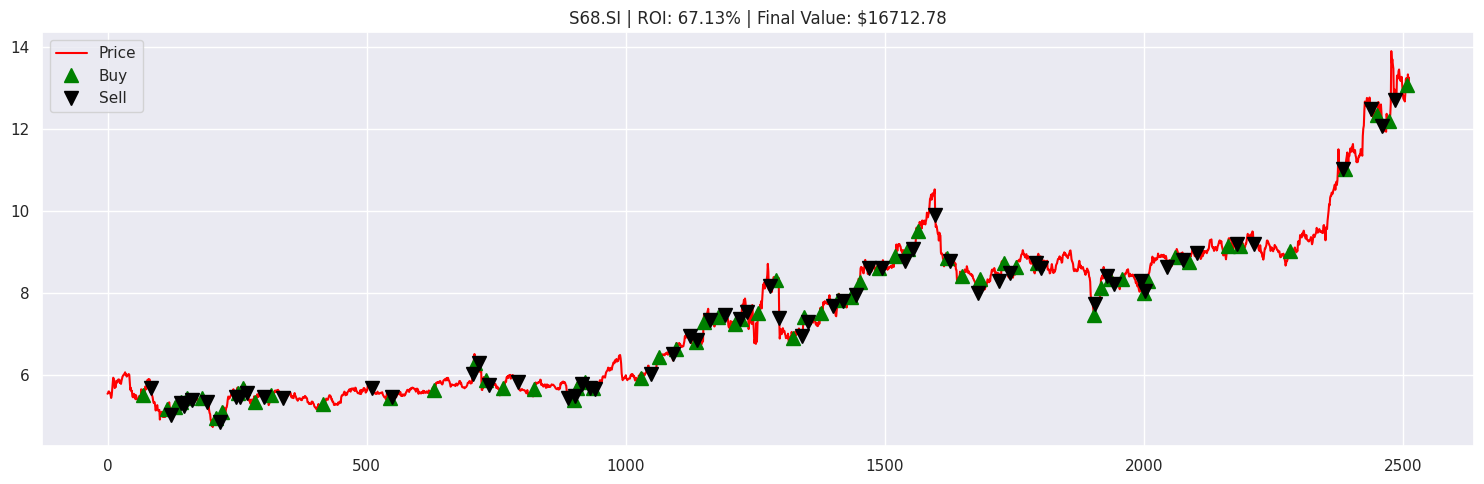


Processing S63.SI...
S63.SI: Final Portfolio = 2.6965362635855854, Shares Held = 4948.0, Last Price = 6.730000019073486


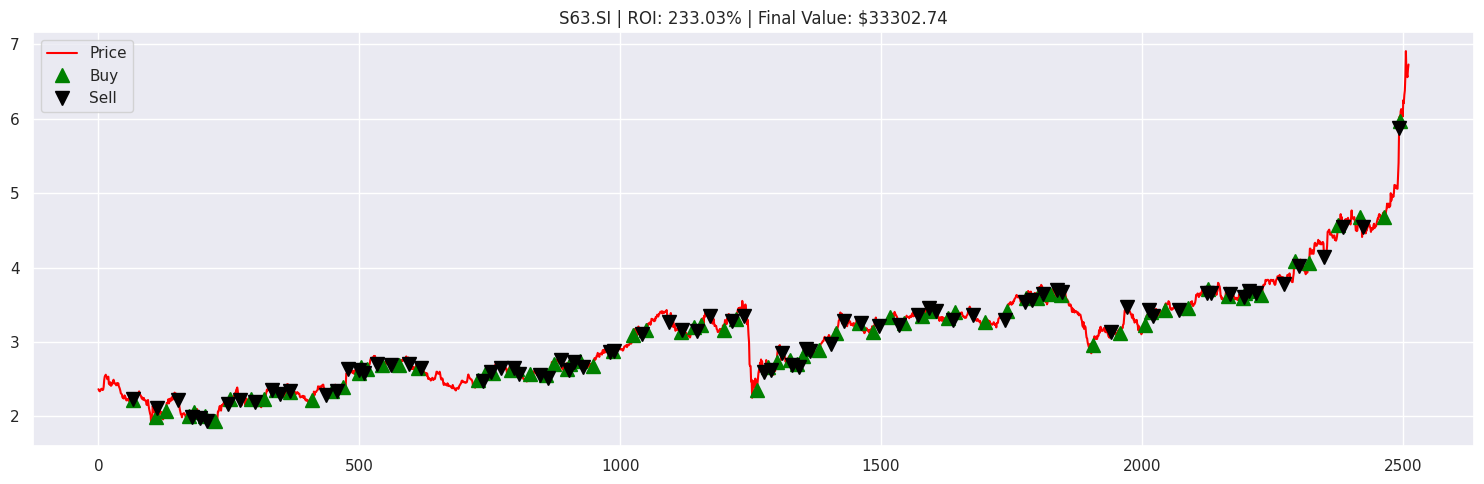


Processing AJBU.SI...
AJBU.SI: Final Portfolio = 42970.19098529685, Shares Held = 0, Last Price = 2.190000057220459


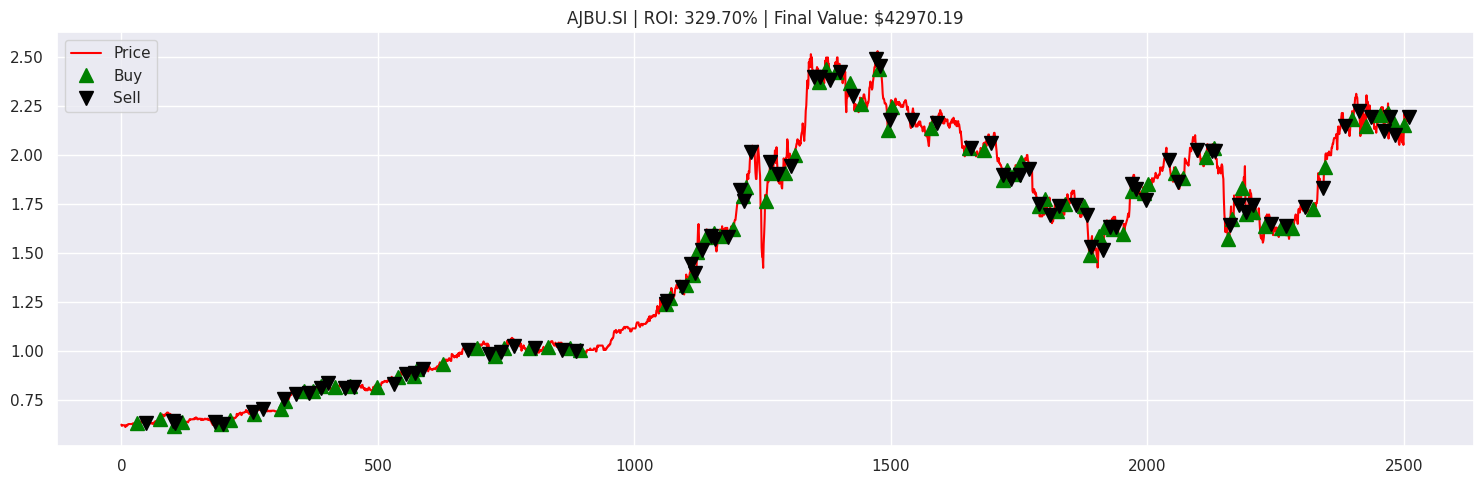


Portfolio Summary:
                ROI   Final Value
U11.SI   165.578330  26557.832999
C38U.SI   91.112910  19111.291008
Q0F.SI    72.787608  17278.760790
S68.SI    67.127822  16712.782214
S63.SI   233.027366  33302.736631
AJBU.SI  329.701910  42970.190985


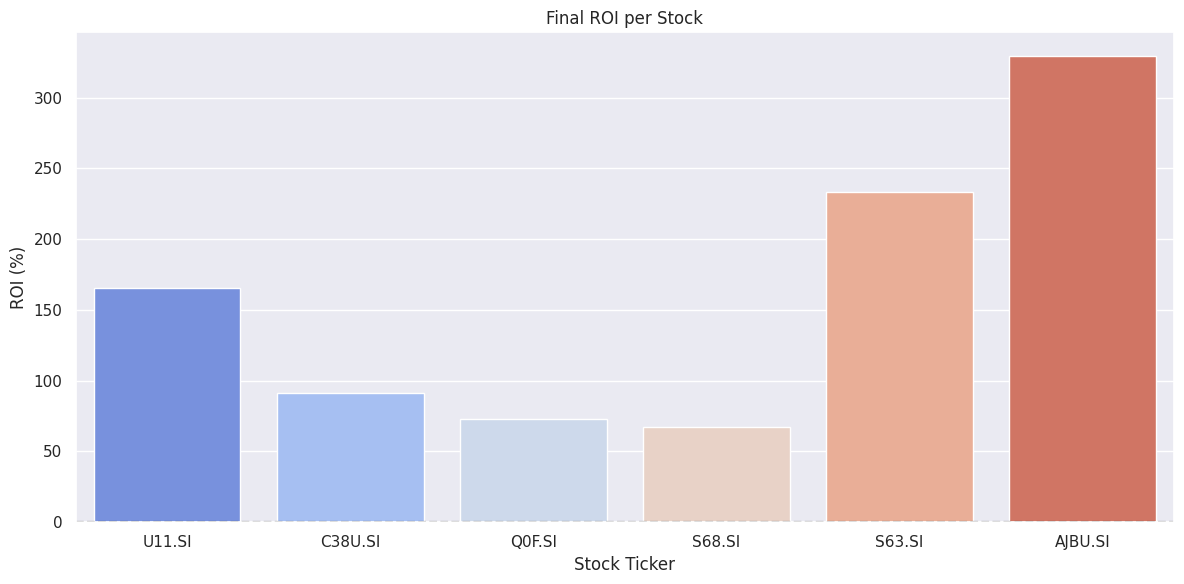

In [7]:
# Long-Term RL Strategy with Adaptive Signal Blending, Trend Confirmation & Dynamic Scaling + Evolutionary Agent

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.00125
alpha_threshold = 0.004
beta_threshold = -0.004
risk_rsi_low = 30
risk_rsi_high = 70
min_trade_profit = 0.002
volatility_buffer = 0.008
trend_confirm_window = 10
macd_weight = 0.5
rsi_weight = 0.3
trend_weight = 0.2


def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)


def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)


def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values


def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])


def compute_volatility(prices):
    returns = np.diff(prices) / prices[:-1]
    return np.std(returns[-10:])


def is_uptrend(prices):
    trend = np.polyfit(range(len(prices)), prices, 1)[0]
    return trend > 0


class EvolutionaryAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

    def get_action(self, weighted_signal, expected_profit, shares_held, vol, current_price):
        if weighted_signal > alpha_threshold and expected_profit > min_trade_profit * current_price and vol > volatility_buffer:
            return 1
        elif weighted_signal < beta_threshold and shares_held > 0 and vol > volatility_buffer:
            return 2
        else:
            return 0


portfolio_results = {}
tickers = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    df = df.dropna(subset=["Close"])  # Drop any NaNs in Close
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    agent = EvolutionaryAgent(window_size - 1 + 3, 3)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        vol = compute_volatility(close[max(0, t-20):t+1])
        trend_score = 1 if is_uptrend(close[max(0, t-trend_confirm_window):t+1]) else -1

        weighted_signal = macd_weight * macd_diff + rsi_weight * ((50 - rsi_val) / 50) + trend_weight * trend_score
        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        action = agent.get_action(weighted_signal, expected_profit, shares_held, vol, current_price)

        if action == 1 and portfolio >= current_price * (1 + commission):
            shares_to_buy = portfolio // (current_price * (1 + commission))
            portfolio -= shares_to_buy * current_price * (1 + commission)
            shares_held += shares_to_buy
            states_buy.append(t)

        elif action == 2 and shares_held > 0:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)
    
    print(f"{ticker}: Final Portfolio = {portfolio}, Shares Held = {shares_held}, Last Price = {close[-1]}")


    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv("/home/priya/Desktop/fyp/Agents/results_evolutionstrategy.csv")
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()